In [1]:
!pip3 install numpy==1.16.2
!pip3 install tables==3.5.1
!pip3 install catboost

     |████████████████████████████████| 17.3MB 6.5MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.17.4
    Uninstalling numpy-1.17.4:
      Successfully uninstalled numpy-1.17.4


     |████████████████████████████████| 4.3MB 6.7MB/s 
  Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4
     |████████████████████████████████| 63.6MB 1.5MB/s 


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
import gc
import math
import random
import matplotlib
# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.patches as patches
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
pd.set_option('max_columns', 100)
pd.set_option('max_rows', 30)
from datetime import datetime
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
path='../input/ashrae-energy-prediction/'
path_new = '../input/lag-transform/'
path_new = '../input/transformer/'
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from math import log
import lightgbm as lgb
import datetime
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
pd.options.mode.chained_assignment = None
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import holidays
import os
from catboost import Pool, CatBoostRegressor

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))
def ls():
     print([v for v in globals().keys() if not v.startswith('_')])

def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    
def free_space(del_list):
    for name in del_list:
        if not name.startswith('_'):
            del globals()[name]
    gc.collect()
    
def chunk_predictor(X,model,n=100,verbose=True):
    predict_fold = KFold(n)
    result = np.zeros(X.shape[0])
    if verbose:
        for trn_idx, val_idx in tqdm_notebook(predict_fold.split(X)):
               result[val_idx] = model.predict(X.iloc[val_idx,:])
    else:
        for trn_idx, val_idx in predict_fold.split(X):
            result[val_idx] = model.predict(X.iloc[val_idx,:])
    return(result)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
path_load = '/content/drive/My Drive/Ashae/'
train = pd.read_hdf(f'{path_load}dataset.h5',key='train')
column = pd.read_hdf(f'{path_load}dataset.h5',key='column')['column'].tolist()
category_column = pd.read_hdf(f'{path_load}dataset.h5',key='category_column')['cat_column'].tolist()
target = pd.read_hdf(f'{path_load}dataset.h5',key='target_site0_mod')
gc.collect()

88

In [4]:
SEED = 42
seed_everything(SEED)
gc.collect()

0

In [0]:
seed = 1
params = {
    'iterations':5000,
    'learning_rate': .03,
    'metric_period': 10,
    'depth': 6,
    'random_strength': 1,
    'eval_metric': 'RMSE',
    'loss_function': 'RMSE',
    'verbose':10,
    'random_state':seed,
    'task_type' : 'GPU',
    'early_stopping_rounds' : 20,
}


In [6]:
%%time
strat =train['building_id'].astype(str).copy() + train['meter'].astype(str).copy()
le = LabelEncoder()
strat = le.fit_transform(strat).astype(np.int16)
free_space(['le'])
gc.collect()

CPU times: user 30 s, sys: 1.88 s, total: 31.9 s
Wall time: 31.9 s


In [0]:
leak = [0,1,2,15]
weight_train = train['building_id'].map(1/train['building_id'].value_counts())
weight_test = (~np.isin(train['site_id'],leak)).astype(int)

In [8]:
%%time
gc.collect()
num_boost=0

score = 0
n_fold = 2
folds = StratifiedKFold(n_splits=n_fold, shuffle=False,random_state=0)
pred = np.zeros(train.shape[0])
model5 =[]

gc.collect()
for fold_ , (trn_idx, val_idx) in tqdm_notebook(enumerate(folds.split(train,strat))):
        gc.collect()
        model = CatBoostRegressor(**params)
        print('Pooling model {}'.format(fold_))
        train_pool = Pool(train.iloc[trn_idx,:], label= target.iloc[trn_idx],cat_features = category_column)
        valid_pool = Pool(train.iloc[val_idx,:], label= target.iloc[val_idx],cat_features = category_column, weight = weight_test[val_idx])
        print('Beginning Model {}'.format(fold_))
        model.fit(train_pool, eval_set = valid_pool,verbose=True,use_best_model=True)

        model5.append(model)
        num_boost += model.get_best_iteration()/n_fold        

        pred[val_idx] = chunk_predictor(train.iloc[val_idx,:],model,verbose=False)
        
        score_temp = model.score(valid_pool)
        score += score_temp/n_fold #math.sqrt(mean_squared_error(valid_y,pred[val_idx]))/n_fold
        print('Fold: {}; RMSE: {:.3f}\n'.format(fold_,score_temp/n_fold))
        free_space(['model','trn_idx','val_idx'])
        
print('RLMSE : {} ; iteration : {}\n'.format(score,num_boost))
valid_build = train['building_id'].copy()
valid_meter = train['meter'].copy()
gc.collect()

Pooling model 0
Beginning Model 0
0:	learn: 1.9485967	test: 1.9917007	best: 1.9917007 (0)	total: 3.02s	remaining: 2h 30m 59s
10:	learn: 1.6783672	test: 1.7404440	best: 1.7404440 (10)	total: 32s	remaining: 2h 25m 8s
20:	learn: 1.4978285	test: 1.5918481	best: 1.5918481 (20)	total: 59.3s	remaining: 2h 20m 8s
30:	learn: 1.3714387	test: 1.5074383	best: 1.5074383 (30)	total: 1m 28s	remaining: 2h 22m 2s
40:	learn: 1.2863291	test: 1.4413339	best: 1.4413339 (40)	total: 1m 56s	remaining: 2h 20m 31s
50:	learn: 1.2265463	test: 1.4062257	best: 1.4062257 (50)	total: 2m 24s	remaining: 2h 18m 59s
60:	learn: 1.1885569	test: 1.3721611	best: 1.3721611 (60)	total: 2m 52s	remaining: 2h 18m 14s
70:	learn: 1.1571873	test: 1.3434936	best: 1.3434936 (70)	total: 3m 19s	remaining: 2h 16m 54s
80:	learn: 1.1326827	test: 1.3150919	best: 1.3150919 (80)	total: 3m 45s	remaining: 2h 15m 37s
90:	learn: 1.1147174	test: 1.2951276	best: 1.2951276 (90)	total: 4m 10s	remaining: 2h 13m 34s
100:	learn: 1.0979476	test: 1.275388

In [9]:
result = pd.DataFrame({'Building_ID':valid_build,'meter':valid_meter,'target_real':target,'target_pred':pred}).dropna()
result.reset_index(drop=True,inplace=True)
gc.collect()

free_space(['valid_build','valid_meter','pred'])

gc.collect()

0

In [10]:
%%time
test = pd.read_hdf(f'{path_load}dataset.h5',key='test')

gc.collect()

pred_test = np.zeros(test.shape[0])

print('Begin scoring test set...\n')

feature_importances = pd.DataFrame()
feature_importances['feature'] = test.columns

for fold_, mod in tqdm_notebook(enumerate(model5)):
    feature_importances['fold_{}'.format(fold_ + 1)] = mod.get_feature_importance()
    pred_test += np.expm1(chunk_predictor(test,mod,verbose=False))/n_fold

Begin scoring test set...




CPU times: user 2h 13min 10s, sys: 7 s, total: 2h 13min 17s
Wall time: 58min 39s


In [0]:
pred_test[(test.site_id==0) & (test.meter==0)] = pred_test[(test.site_id==0) & (test.meter==0)] * 3.4118

gc.collect()
sample_submission = pd.read_csv(f'{path_load}sample_submission.csv')
sample_submission['meter_reading'] = pred_test
sample_submission.loc[sample_submission['meter_reading']<0, 'meter_reading'] = 0
sample_submission.to_csv('{}submission/submission_catboost_score{}.csv'.format(path_load,score),index=False)

In [12]:
sample_submission.iloc[:50,:]

,row_id,meter_reading
0,0,87.104772
1,1,30.774387
2,2,25.041600
3,3,279.609085
4,4,696.101244
...,...,...
45,45,102.423701
46,46,191.834875
47,47,358.117351
48,48,251.967155


In [0]:
def fun_rmse_group(x):
    return(math.sqrt(mean_squared_error(x['target_real'],x['target_pred'])))

rmse_group_data = result.groupby(['Building_ID','meter']).apply(fun_rmse_group)
score_by_group = rmse_group_data.mean()

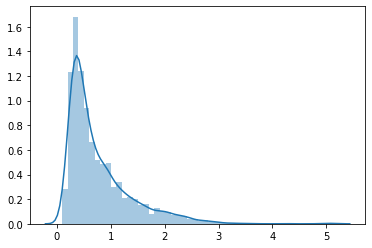

In [14]:
sns.distplot(rmse_group_data,label='RMSE by Building ID and meter')

In [15]:
print('Mean RMSLE by building and meter : {}'.format(score_by_group))

Mean RMSLE by building and meter : 0.7702739587285012


In [0]:
error_id = rmse_group_data.sort_values(ascending =False)
error_id = pd.DataFrame({'building_id':rmse_group_data.sort_values(ascending =False).index.get_level_values('Building_ID'),
                         'meter':rmse_group_data.sort_values(ascending =False).index.get_level_values('meter'),'error':error_id.values})
error_id.to_csv('error_by_id.csv',index=False)

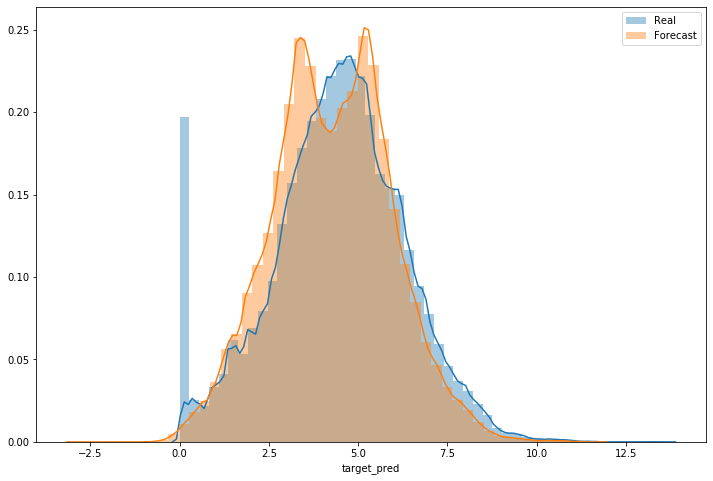

In [17]:
fig = plt.figure(figsize=(12,8))
sns.distplot(result.target_real,label='Real')
sns.distplot(result.target_pred,label='Forecast')
plt.legend()


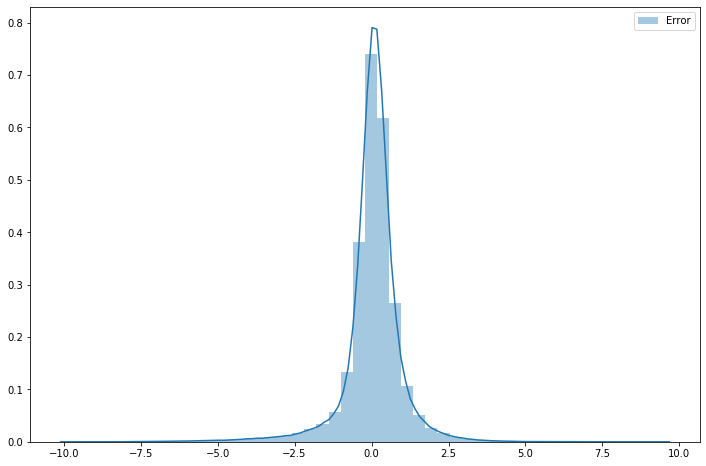

In [18]:
import seaborn as sns 
fig = plt.figure(figsize=(12,8))
sns.distplot((result.target_real-result.target_pred),label ='Error')
plt.legend()


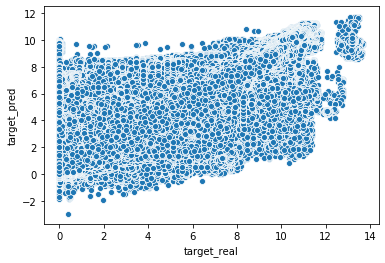

In [19]:
sns.scatterplot(x=result.target_real, y=result.target_pred)


Text(0.5, 1.0, '50 TOP feature importance over 2 average')

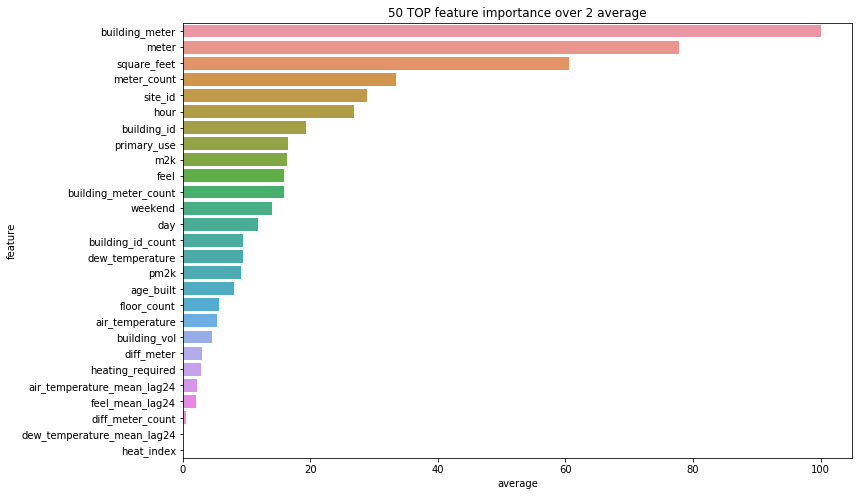

In [20]:
scaler = MinMaxScaler(feature_range=(0, 100))


feature_importances['average'] = scaler.fit_transform(X=pd.DataFrame(feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)))
# feature_importances.to_csv('feature_importances.csv',index=False)

fig = plt.figure(figsize=(12,8))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} average'.format(fold_+1))
